In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

In [19]:
def load_data(path_data = 'dataset/'):    
    data = []
    labels = []
    file_name = []
    
    for sub_folder in os.listdir(path_data):
        sub_folder_files = os.listdir(os.path.join(path_data, sub_folder))
        for i, filename in enumerate(sub_folder_files):
            img_path = os.path.join(path_data, sub_folder, filename)
            
            img = cv.imread(img_path)
            img = img.astype(np.uint8)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (300, 300))
            
            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)
            
    print(len(data), len(labels), len(file_name))
    return data, labels, file_name


In [20]:
data, labels, file_name = load_data('dataset/')

2159 2159 2159


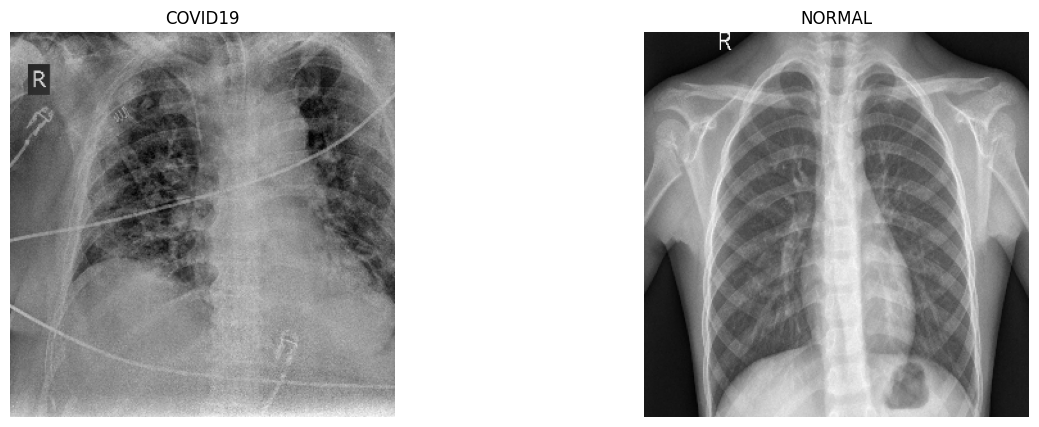

In [21]:
sample_data = []
sample_labels = []
for label in set(labels):
    idx = labels.index(label)
    sample_data.append(data[idx])
    sample_labels.append(labels[idx])

# Display the samples using matplotlib.pyplot
fig, axs = plt.subplots(1, len(set(labels)), figsize=(15, 5))
for i, (img, label) in enumerate(zip(sample_data, sample_labels)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()

In [ ]:
def tresholding(img, treshold):
    img[img < treshold] = 0
    img[img >= treshold] = 255
    return img

def normalize(img):
	img = img.astype(np.float32)
	img = (img - img.min()) / (img.max() - img.min())
	img = (img * 255).astype(np.uint8)
	return img

def resize_image(image, target_size):

    original_height, original_width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * original_width / target_width)
            original_y = int(i * original_height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [ ]:
def glcm(image, derajat):
    directions = {
        0: (0, 1),
        45: (-1, 1),
        90: (-1, 0),
        135: (-1, -1)
    }
    if derajat not in directions:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    d = directions[derajat]
    max_val = 256
    glcm = np.zeros((max_val, max_val))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if 0 <= i + d[0] < image.shape[0] and 0 <= j + d[1] < image.shape[1]:
                glcm[image[i, j], image[i + d[0], j + d[1]]] += 1

    glcm /= glcm.sum()
    return glcm

def calc_properties(glcm):
    I, J = np.ogrid[0:glcm.shape[0], 0:glcm.shape[1]]
    contrast = np.sum(glcm * (I - J) ** 2)
    dissimilarity = np.sum(glcm * np.abs(I - J))
    homogeneity = np.sum(glcm / (1.0 + (I - J) ** 2))
    ASM = np.sum(glcm ** 2)
    energy = np.sqrt(ASM)
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    mean_i = np.sum(I * glcm)
    mean_j = np.sum(J * glcm)
    std_i = np.sqrt(np.sum((I - mean_i) ** 2 * glcm))
    std_j = np.sqrt(np.sum((J - mean_j) ** 2 * glcm))
    correlation = np.sum(((I - mean_i) * (J - mean_j) * glcm) / (std_i * std_j + (std_i * std_j == 0)))
    
    return contrast, dissimilarity, homogeneity, ASM, energy, entropy, correlation

angles = [0, 45, 90, 135]
properties = ["Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Entropy", "Correlation"]
results = {f"{prop}{angle}": [] for angle in angles for prop in properties}

for img in data:
    for angle in angles:
        glcm_matrix = glcm(img, angle)
        props = calc_properties(glcm_matrix)
        for prop, value in zip(properties, props):
            results[f"{prop}{angle}"].append(value)

dataTable = {'Filename': file_name, 'Label': labels}
dataTable.update(results)

df = pd.DataFrame(dataTable)
df.to_csv('hasilEkstraksi.csv', index=False)

In [24]:
hasilEkstrak = pd.read_csv('hasilEkstraksi.csv')

In [25]:
hasil = hasilEkstrak.drop(columns=['Filename', 'Label'])
print(hasil.columns)
df = pd.DataFrame(hasil)
df.to_csv('forCorrellation.csv', index=False)

Index(['Contrast0', 'Dissimilarity0', 'Homogeneity0', 'ASM0', 'Energy0',
       'Entropy0', 'Correlation0', 'Contrast45', 'Dissimilarity45',
       'Homogeneity45', 'ASM45', 'Energy45', 'Entropy45', 'Correlation45',
       'Contrast90', 'Dissimilarity90', 'Homogeneity90', 'ASM90', 'Energy90',
       'Entropy90', 'Correlation90', 'Contrast135', 'Dissimilarity135',
       'Homogeneity135', 'ASM135', 'Energy135', 'Entropy135',
       'Correlation135'],
      dtype='object')


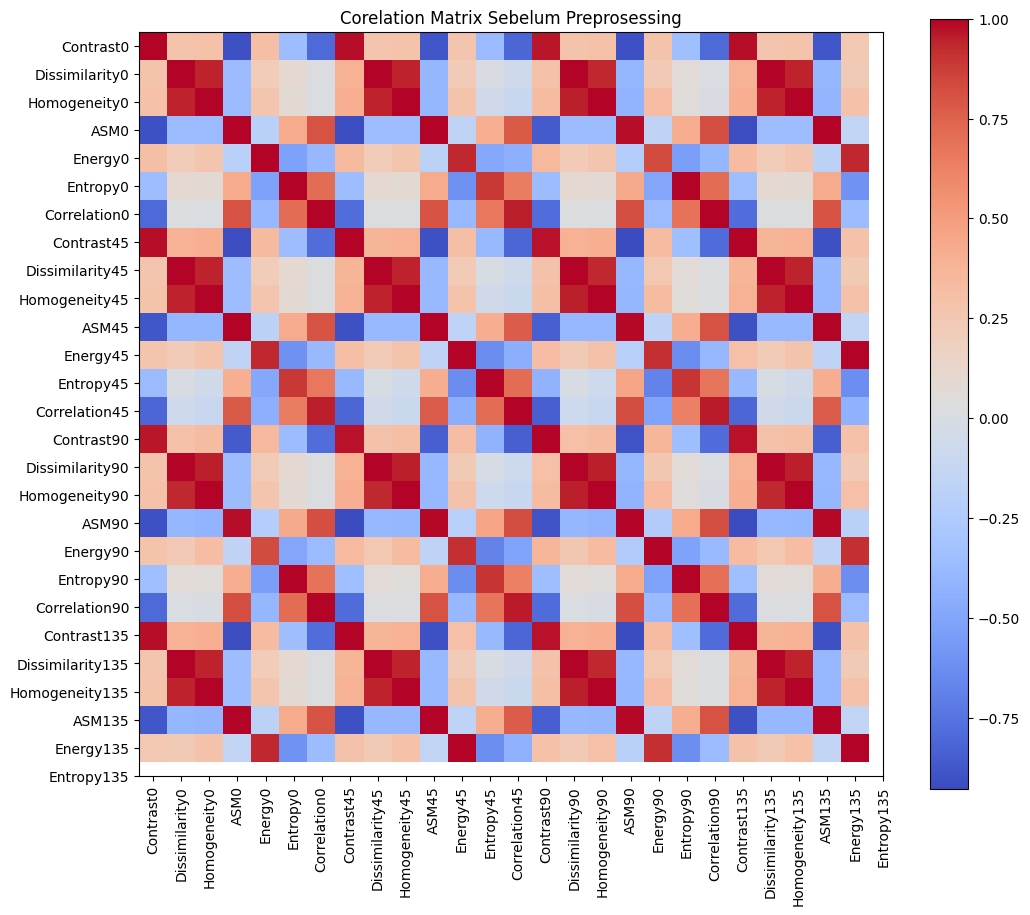

In [26]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)  
        for row in reader:
            data.append(row)
    return headers, data


def modify_labels(data, label_column_index):
    label_mapping = {'normal': 0, 'covid': 1}
    for row in data:
        row[label_column_index] = label_mapping.get(row[label_column_index], row[label_column_index])
    return data


def calculate_correlation_matrix(data):
    data = np.array(data, dtype=float)
    n = data.shape[1]
    correlation_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            correlation_matrix[i, j] = calculate_correlation(data[:, i], data[:, j])
    return correlation_matrix


def calculate_correlation(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x), np.std(y)
    covariance = np.mean((x - mean_x) * (y - mean_y))
    return covariance / (std_x * std_y)


def plot_correlation_matrix(correlation_matrix, headers):
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(headers)), headers, rotation=90)
    plt.yticks(range(len(headers)), headers)
    plt.title("Corelation Matrix Sebelum Preprosessing")
    plt.savefig("Corelation Matrix Sebelum Preprosessing", dpi=200)
    plt.show()

file_path = 'forCorrellation.csv'  
headers, data = read_csv(file_path)

file_names = [row[0] for row in data]
labels = [row[1] for row in data]
data = [row[2:] for row in data]

label_mapping ={'normal': 0, 'covid': 1}
labels = [label_mapping.get(label, label) for label in labels]

data = np.array(data, dtype=float)
features = data
labels = np.array(labels)

correlation_matrix = calculate_correlation_matrix(features)

plot_correlation_matrix(correlation_matrix, headers[:-1])